# pc-gym Test Notebook

Tests constraints, disturbance, oracle on all three models


## Libraries

In [1]:
from dataclasses import dataclass
import numpy as np 
import torch
import matplotlib.pyplot as plt 
import gymnasium as gym
import torch.nn.functional as F
import copy
from stable_baselines3 import PPO,SAC
import pcgym
import jax.numpy as jnp
#Global params
T = 26
nsteps = 100

## Rollout Function

### 1.1 CSTR

In [2]:
#Enter required setpoints for each state. Enter None for states without setpoints.
SP = {
    'Ca': [0.85 for i in range(int(nsteps/2))] + [0.9 for i in range(int(nsteps/2))],
}

#Continuous box action space
action_space = {
    'low': np.array([295]),
    'high':np.array([302]) 
}
#Continuous box observation space
observation_space = {
    'low' : np.array([0.7,300,0.8]),
    'high' : np.array([1,350,0.9])  
}

r_scale ={
    'Ca': 5 #Reward scale for each state
}
env_params = {
    'N': nsteps, # Number of time steps
    'tsim':T, # Simulation Time
    'SP':SP, #Setpoint
    'o_space' : observation_space, #Observation space
    'a_space' : action_space, # Action space
    'x0': np.array([0.8,330,0.8]), # Initial conditions (torch.tensor)
    'model': 'cstr_ode', #Select the model
    'r_scale': r_scale, #Scale the L1 norm used for reward (|x-x_sp|*r_scale)
    'normalise_a': True, #Normalise the actions
    'normalise_o':True, #Normalise the states,
    'noise':True, #Add noise to the states
    'integration_method': 'casadi', #Select the integration method
    'noise_percentage':0.001 #Noise percentage
}
env = pcgym.Models_env(env_params)


In [3]:
initial_policy = SAC.load('.\Test_Policies\SAC_cstr.zip')


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



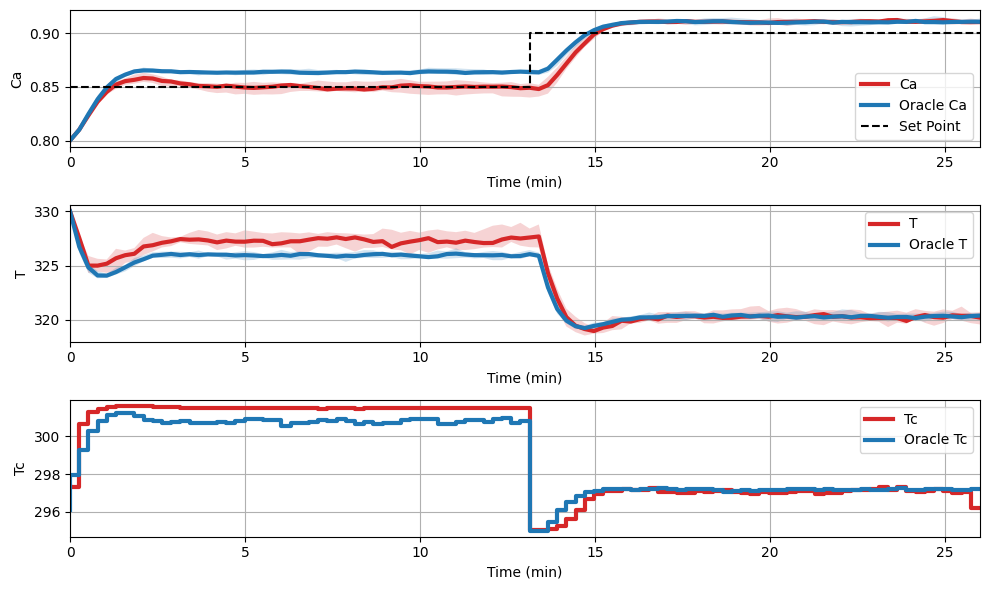

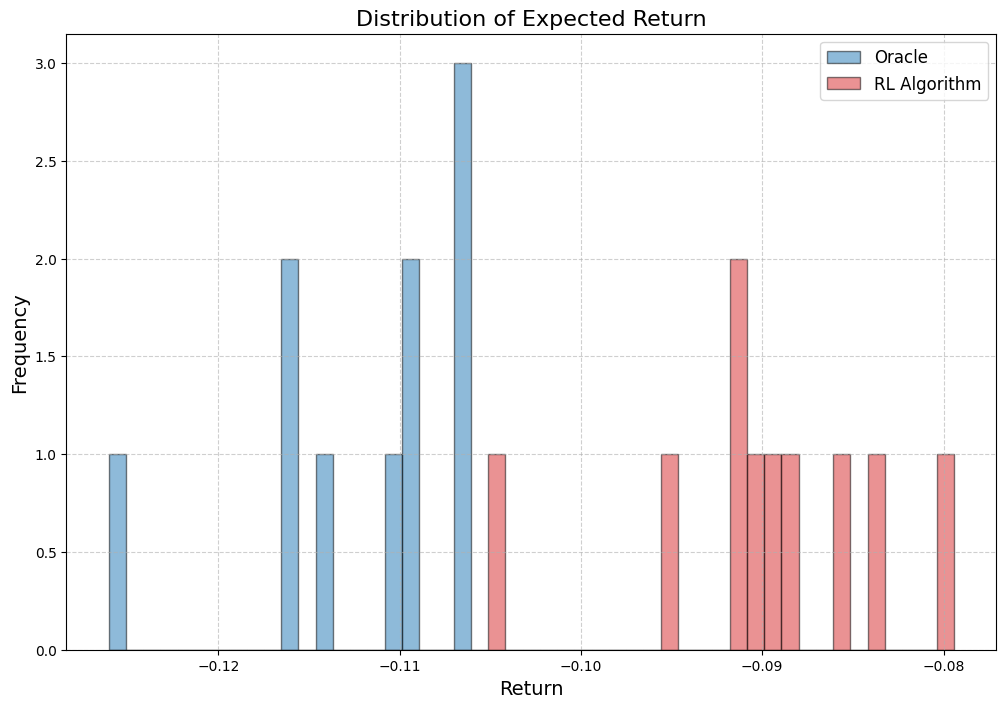

In [4]:
env.plot_rollout(initial_policy,10,oracle = True,dist_reward=True)


### 1.1.1 Reactor with JAX 

In [5]:
#Enter required setpoints for each state. Enter None for states without setpoints.
SP = {
    'Ca': [0.8 for i in range(int(nsteps/2))] + [0.9 for i in range(int(nsteps/2))],
}

#Continuous box action space
action_space = {
    'low': np.array([295]),
    'high':np.array([302]) 
}
#Continuous box observation space
observation_space = {
    'low' : np.array([0.7,300,0.8]),
    'high' : np.array([1,350,0.9])  
}

r_scale ={
    'Ca': 5
}
env_params = {
    'N': nsteps, # Number of time steps
    'tsim':T, # Simulation Time
    'SP':SP, #Setpoint
    'o_space' : observation_space, #Observation space
    'a_space' : action_space, # Action space
    'dt': 1., # Time step
    'x0': np.array([0.8,330,0.8]), # Initial conditions (torch.tensor)
    'model': 'cstr_ode', #Select the model
    'r_scale': r_scale, #Scale the L1 norm used for reward (|x-x_sp|*r_scale)
    'normalise_a': True, #Normalise the actions
    'normalise_o':True, #Normalise the states,
    'noise':True, #Add noise to the states
    'integration_method': 'jax',
    'noise_percentage':0.001
}
env = pcgym.Models_env(env_params)

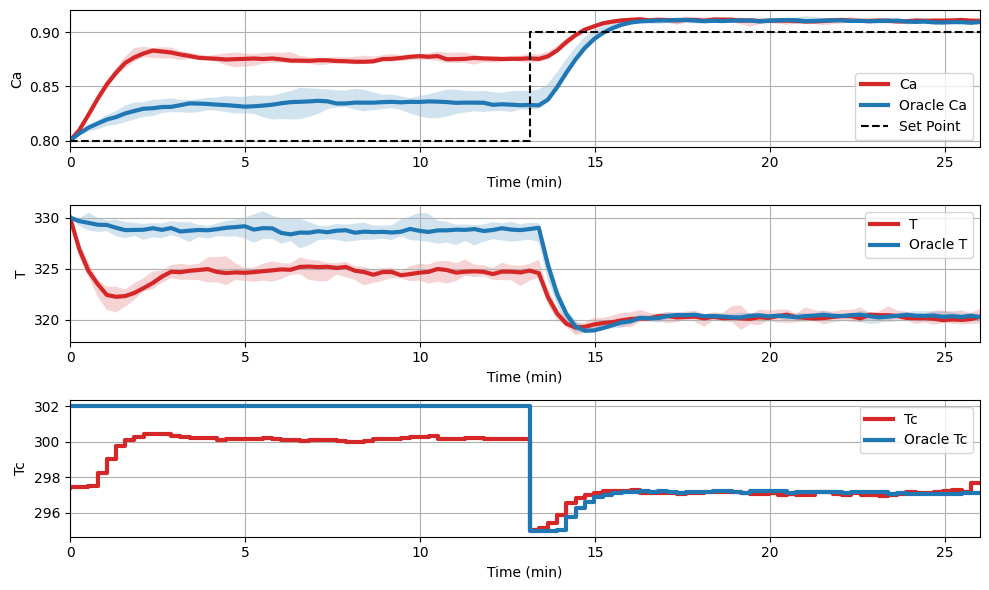

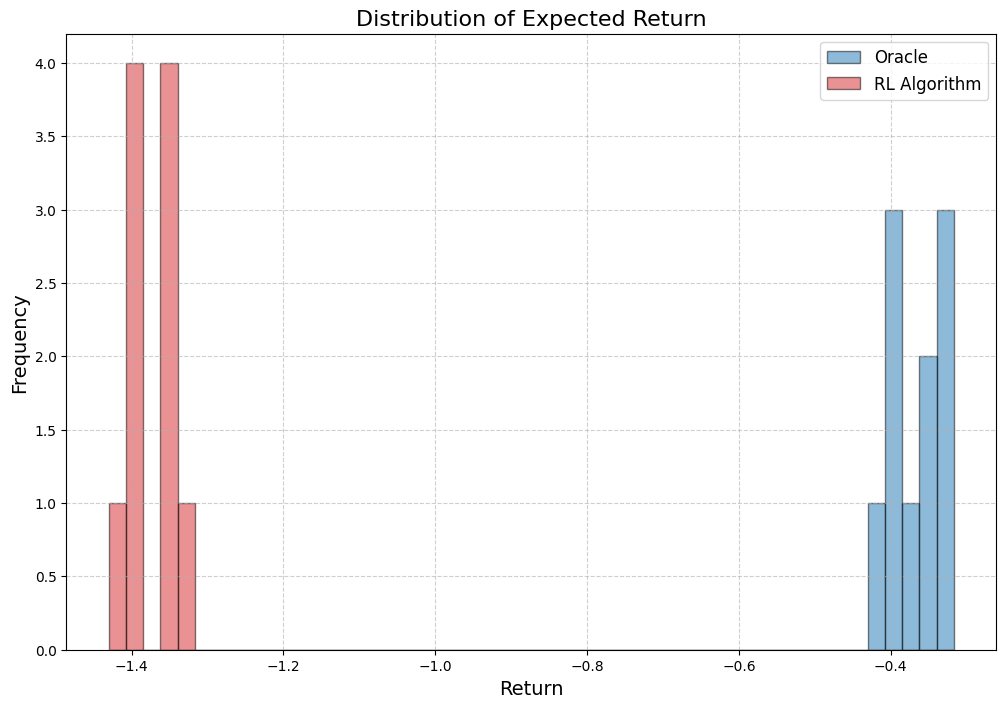

In [6]:
env.plot_rollout(initial_policy,10,oracle = True,dist_reward=True)

### 1.2 First Order System 

In [7]:
SP = {
    'x': [5 for i in range(int(nsteps/2))] + [8 for i in range(int(nsteps/2))]
}

action_space = {
    'low': np.array([0]),
    'high':np.array([10]) 
}

observation_space = {
    'low' : np.array([0,4]),
    'high' : np.array([10,6])  
}

r_scale = {
    'x': 1,
}
env_params_fos = {
    'N': nsteps,
    'tsim':T,
    'SP':SP,
    'o_space' : observation_space,
    'a_space' : action_space,
    'dt': 1,
    'x0': np.array([0.,5.]),
    'model': 'first_order_system_ode', 
    'r_scale': r_scale,
    'normalise_a': True, #Normalise the actions
    'normalise_o':True, #Normalise the states,
    'noise':False, #Add noise to the states
    'noise_percentage':0.01,
    'integration_method': 'casadi'
}
first_order_env = pcgym.Models_env(env_params_fos)

In [8]:
fos_policy = SAC.load('.\Test_Policies\SAC_fos.zip')

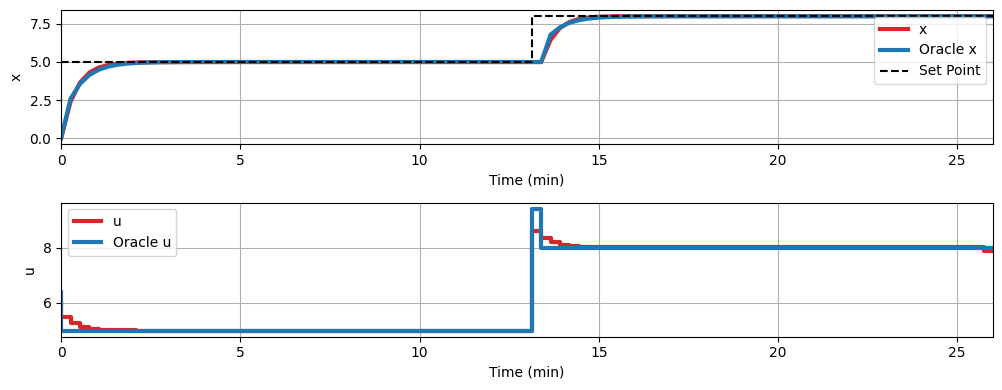

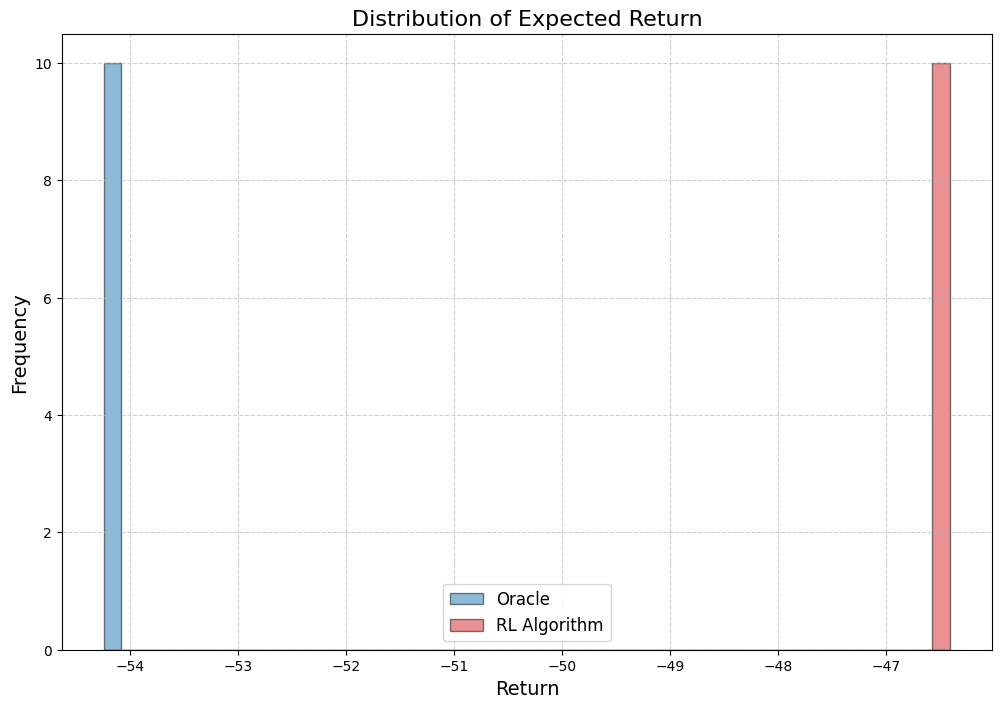

In [9]:
first_order_env.plot_rollout(fos_policy,10,oracle=True,dist_reward=True,MPC_params={'N':10,'R':0.0})

### 1.3 Multi-Stage Extraction Column

In [10]:
SP = {
      'X5': [0.3 for i in range(int(nsteps/4))] + [0.4 for i in range(int(nsteps/2))]+ [0.3 for i in range(int(nsteps/4))],
  }

action_space = {
    'low': np.array([5,10]),
    'high':np.array([500,1000])
}

observation_space = {
    'low' : np.array([0]*10+[0.3]),
    'high' : np.array([1]*10+[0.4])  
}


r_scale = {
    'X5': 1
}
env_params_ms = {
    'N': nsteps,
    'tsim':T,
    'SP':SP,
    'o_space' : observation_space,
    'a_space' : action_space,
    'dt': 1,
    'x0': np.array([0.55, 0.3, 0.45, 0.25, 0.4, 0.20, 0.35, 0.15, 0.25, 0.1,0.3]),
    'model': 'multistage_extraction_ode', 
    'r_scale': r_scale,
    'normalise_a': True, #Normalise the actions
    'normalise_o':True, #Normalise the states,
    'noise':False, #Add noise to the states
    'noise_percentage':0,
    'integration_method': 'casadi'
}
multistage_env = pcgym.Models_env(env_params_ms)



In [11]:
ms_policy = SAC.load(".\Test_Policies\SAC_multistage.zip")


CasADi - 2024-03-07 15:29:35 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 40, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-03-07 15:29:35 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 42, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-03-07 15:29:35 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 20, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-03-07 15:29:37 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 40, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-03-07 15:29:37 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 42, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-03-07 15:29:37 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 40, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-03-07 15:29:37 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 30, co

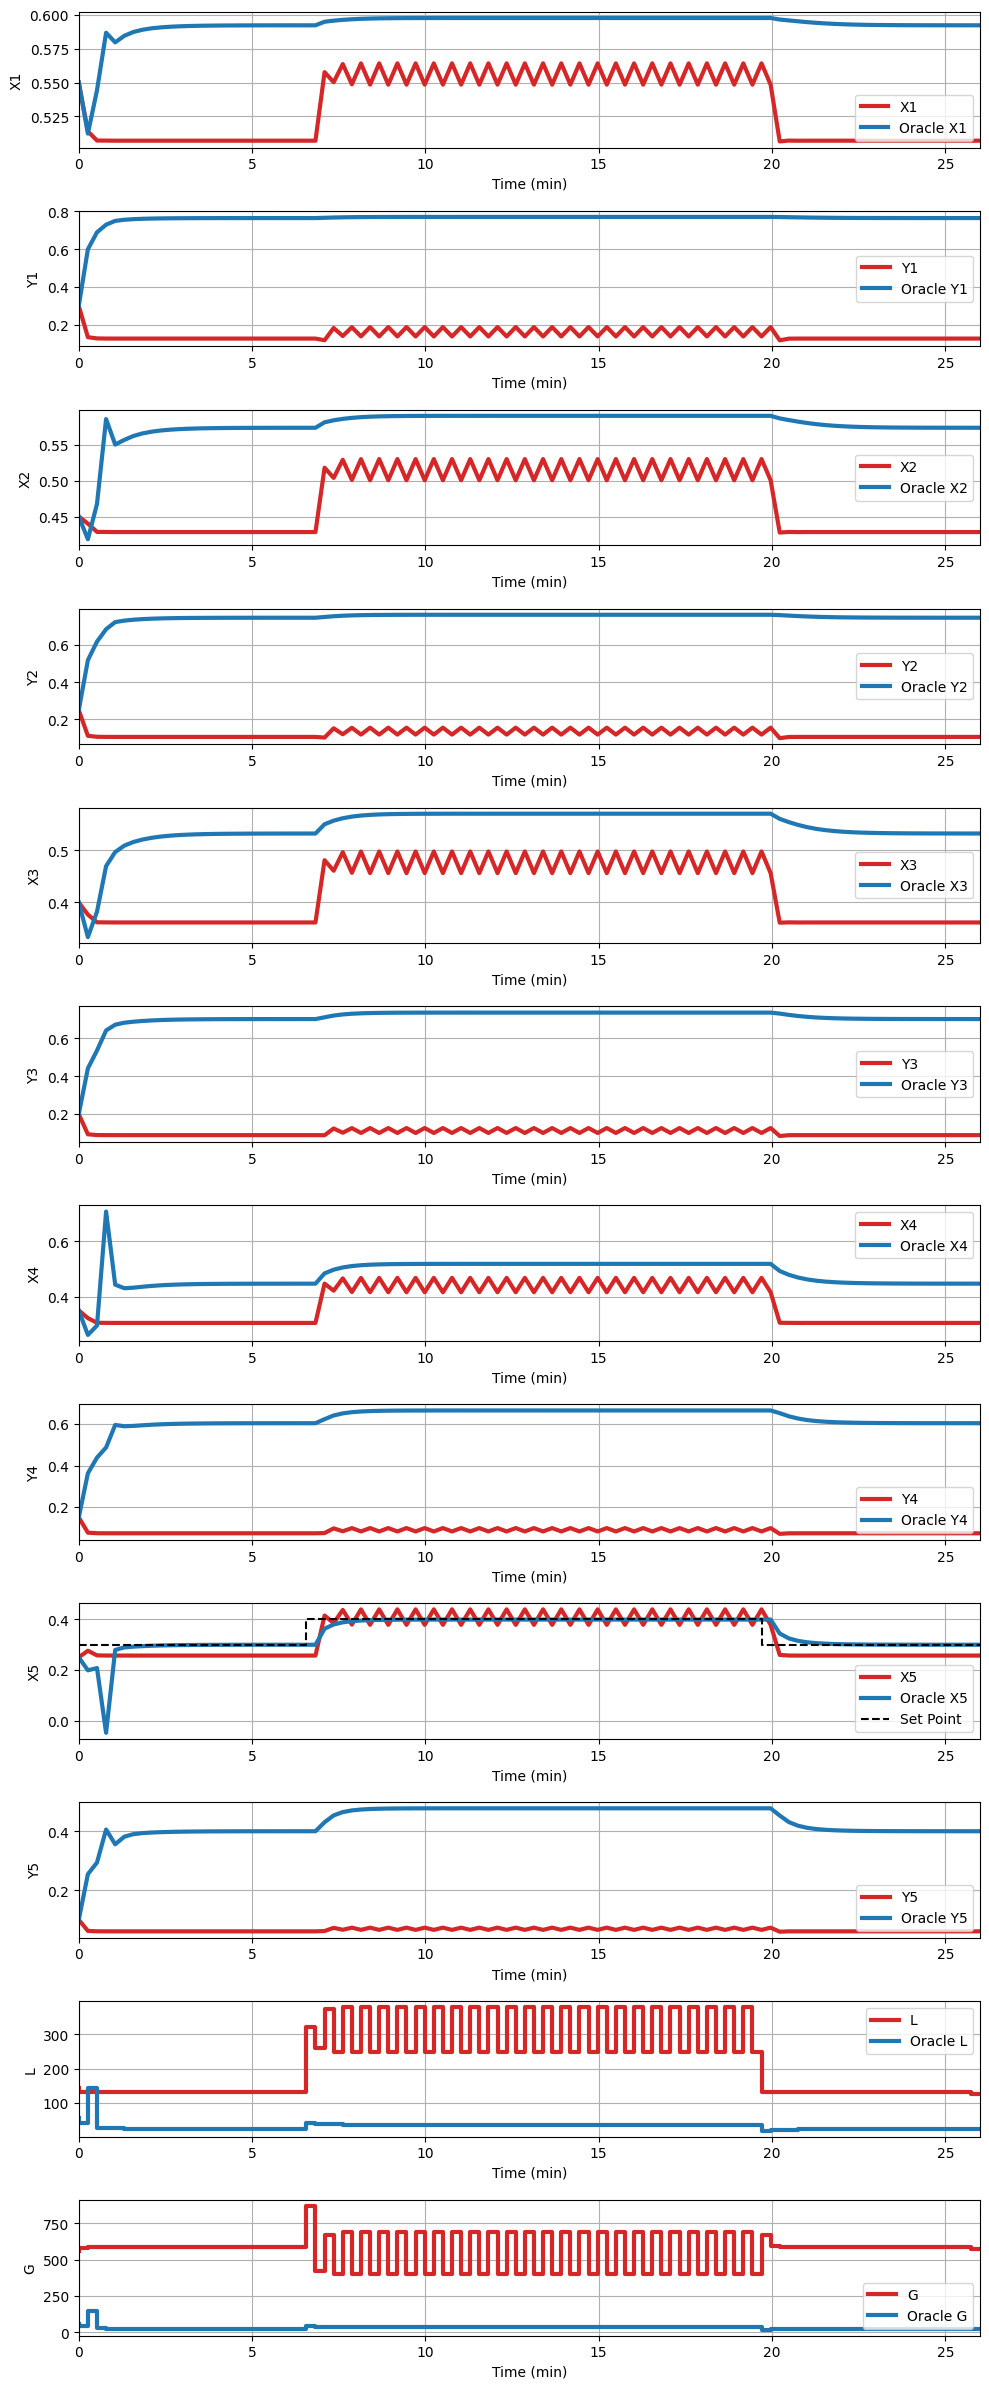

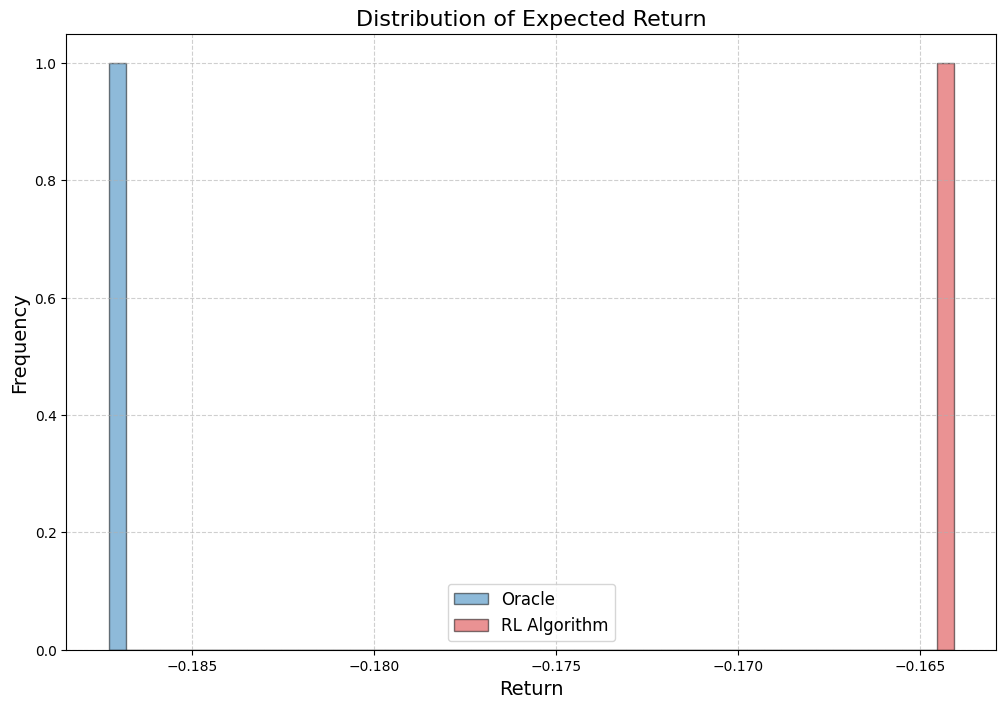

In [12]:
multistage_env.plot_rollout(ms_policy,1,oracle=True,dist_reward=True)

## 2. Disturbance Function

### 2.1 Reactor Disturbance

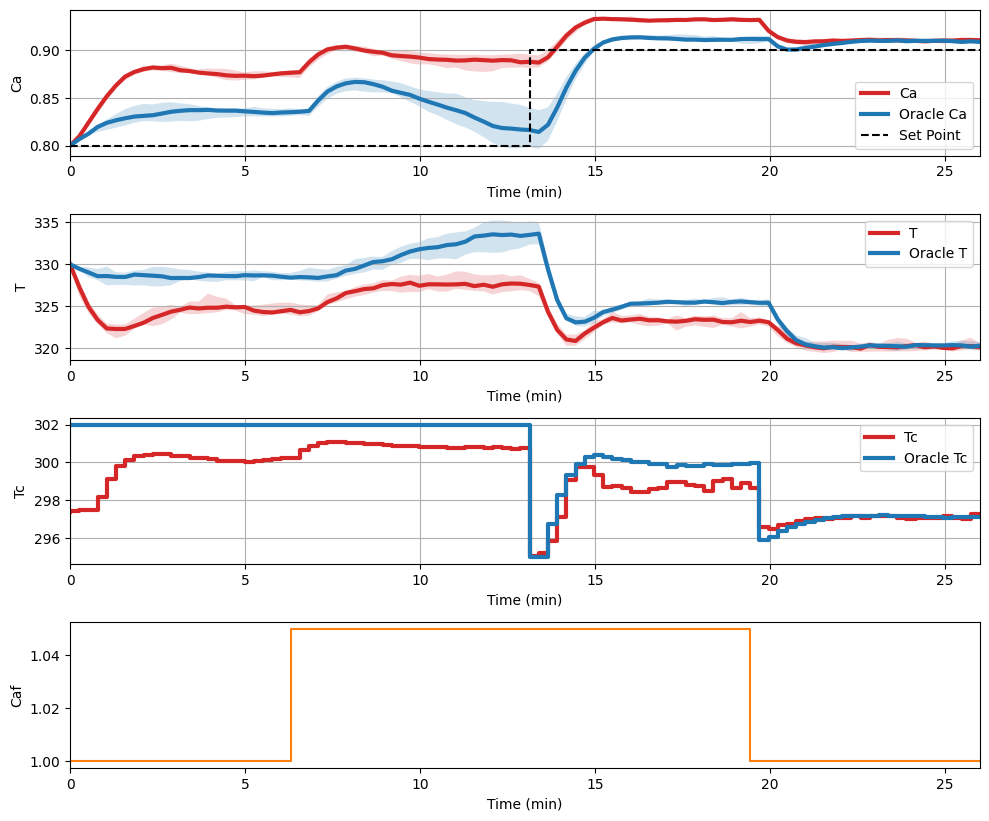

In [13]:
disturbance = {'Caf': np.repeat([1, 1.05, 1], [nsteps//4, nsteps//2, nsteps//4])}
env = pcgym.Models_env({**env_params, 'disturbances': disturbance}).plot_rollout(initial_policy, reps = 10, oracle= True)

### 2.2 Multistage Extraction 

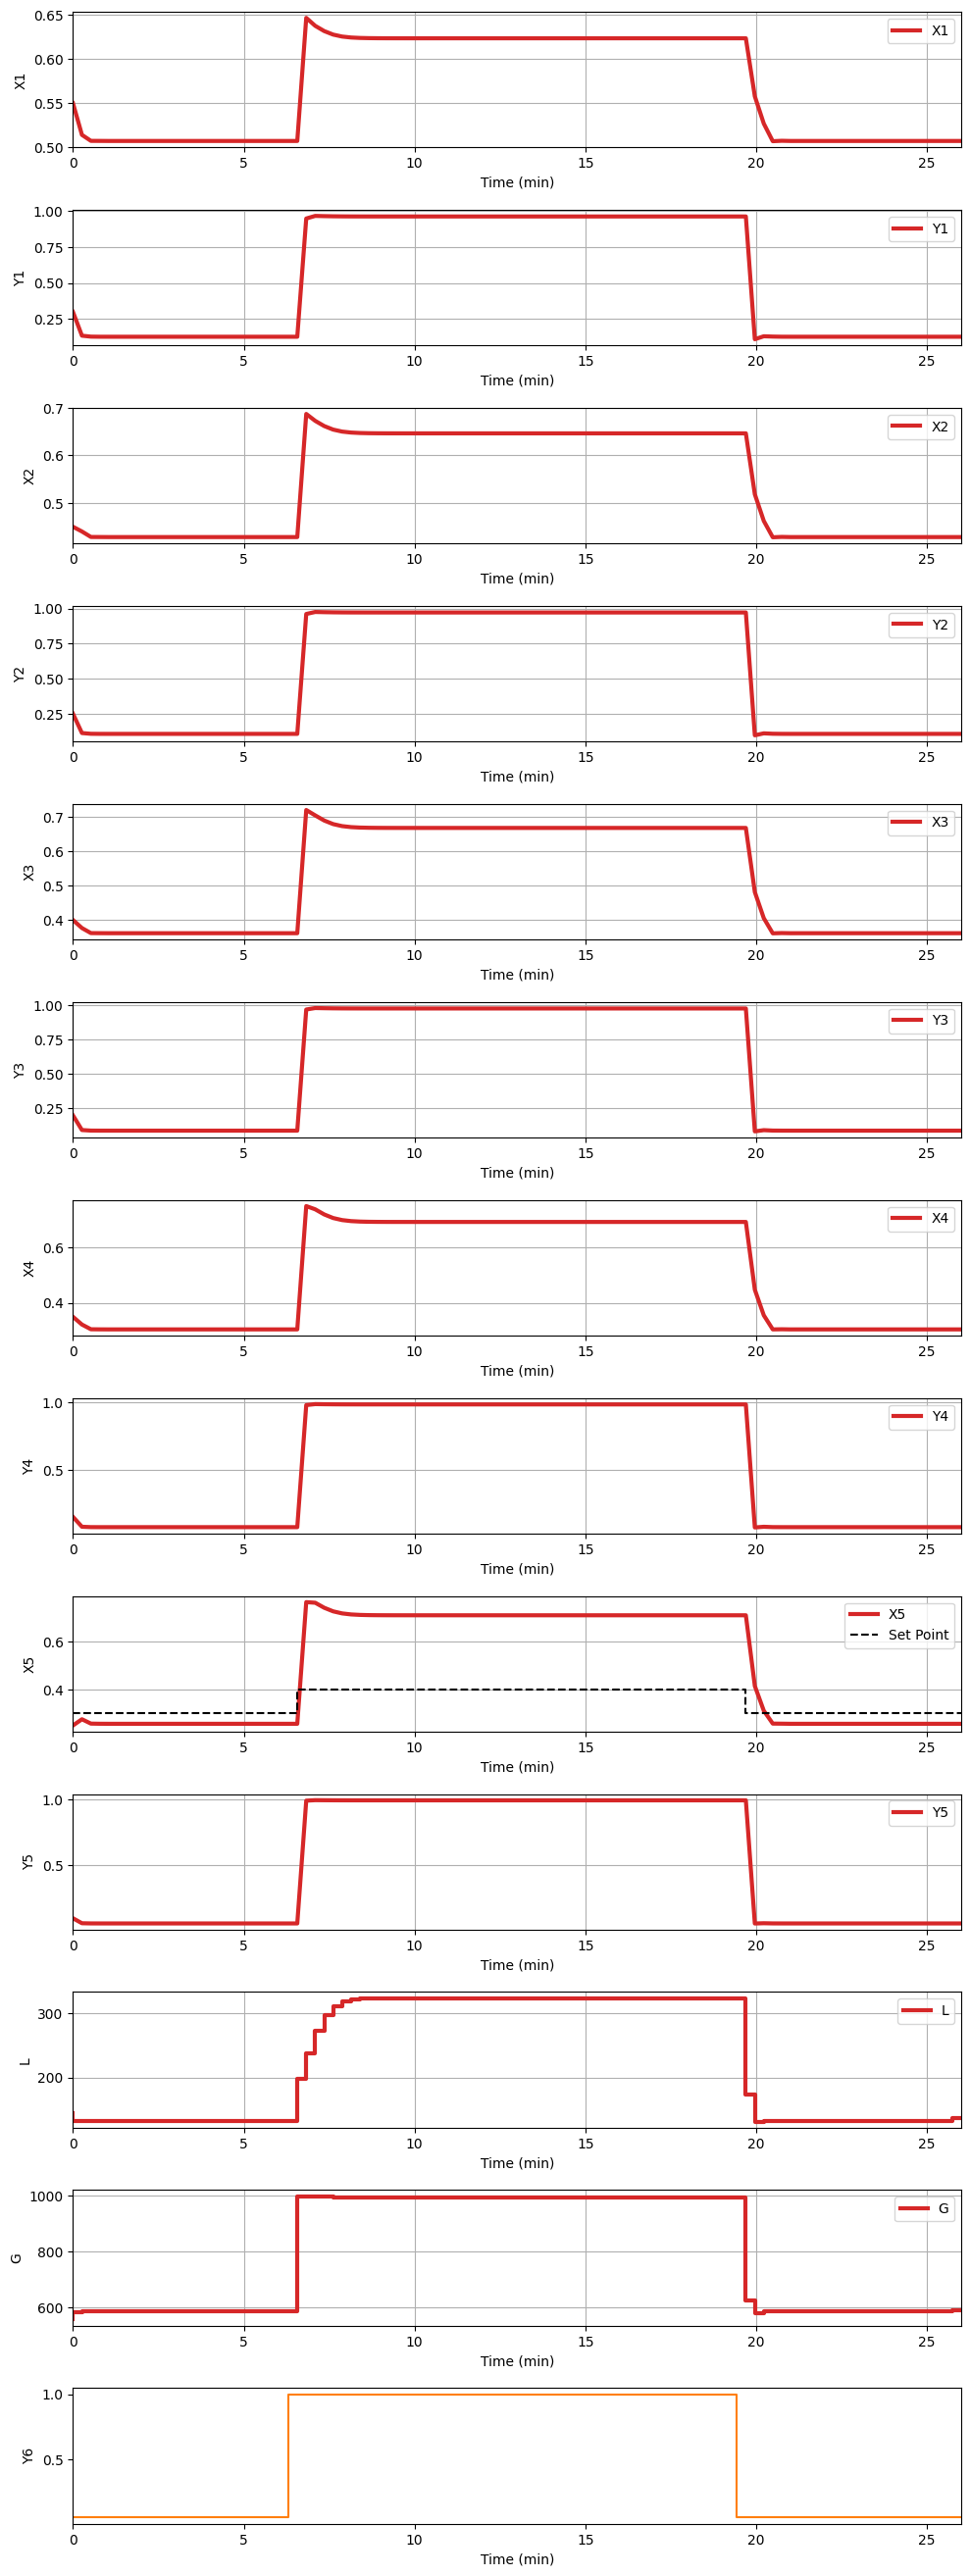

In [14]:
disturbance = {
    'Y6': np.array([0.05 for i in range(int(nsteps/4))]+[1 for i in range(int(nsteps/2))]+[0.05 for i in range(int(nsteps/4))]),
}

env_params_ms.update({'disturbances': disturbance,})
                

multistage_env = pcgym.Models_env(env_params_ms)

multistage_env.plot_rollout(ms_policy,10)

## 3. Constraint Function

### 3.1 Reactor Constraint

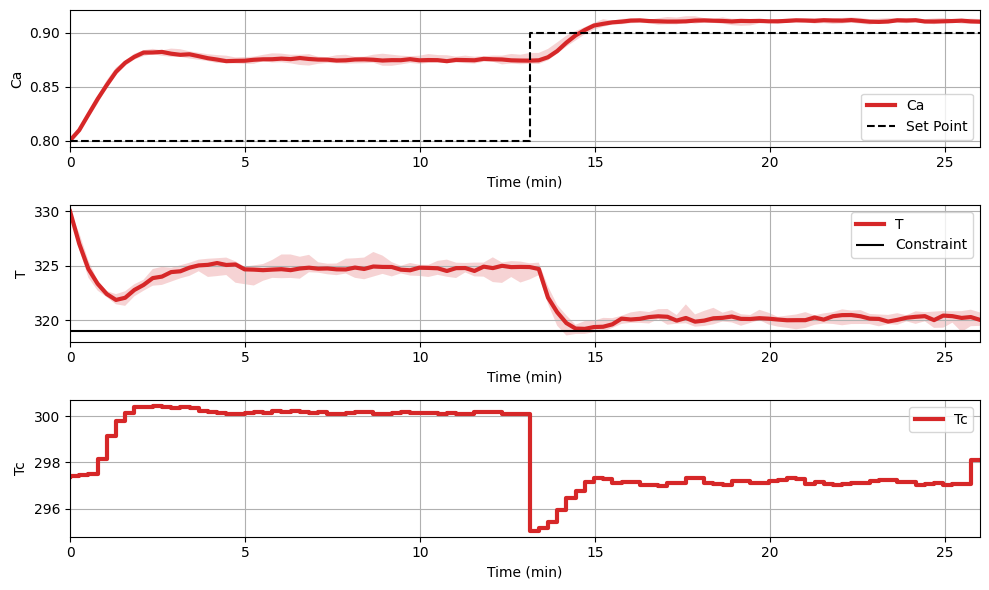

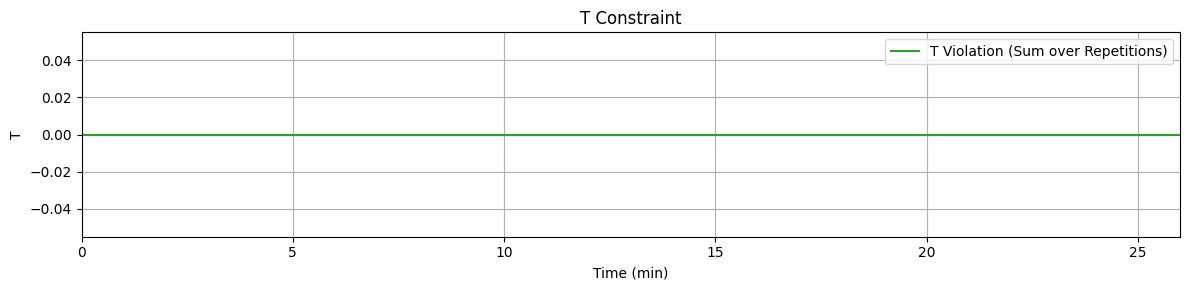

In [15]:
cons = {
    'T': [319]
}

cons_type = {
    'T':'>='
}

env_params.update({
'done_on_cons_vio':False,
'constraints': cons, 
'cons_type': cons_type,
'r_penalty': True})
env_params.pop('disturbances', None)
env = pcgym.Models_env(env_params)
env.plot_rollout(initial_policy,10,cons_viol=True)

### 3.2 First-Order-System Constraint

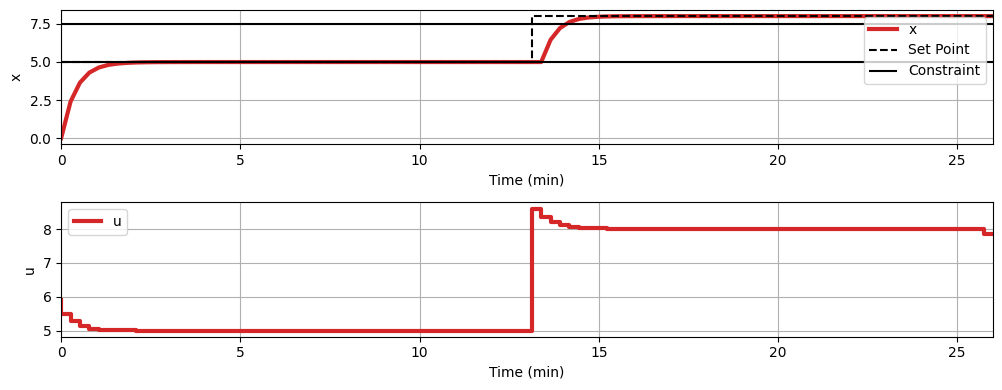

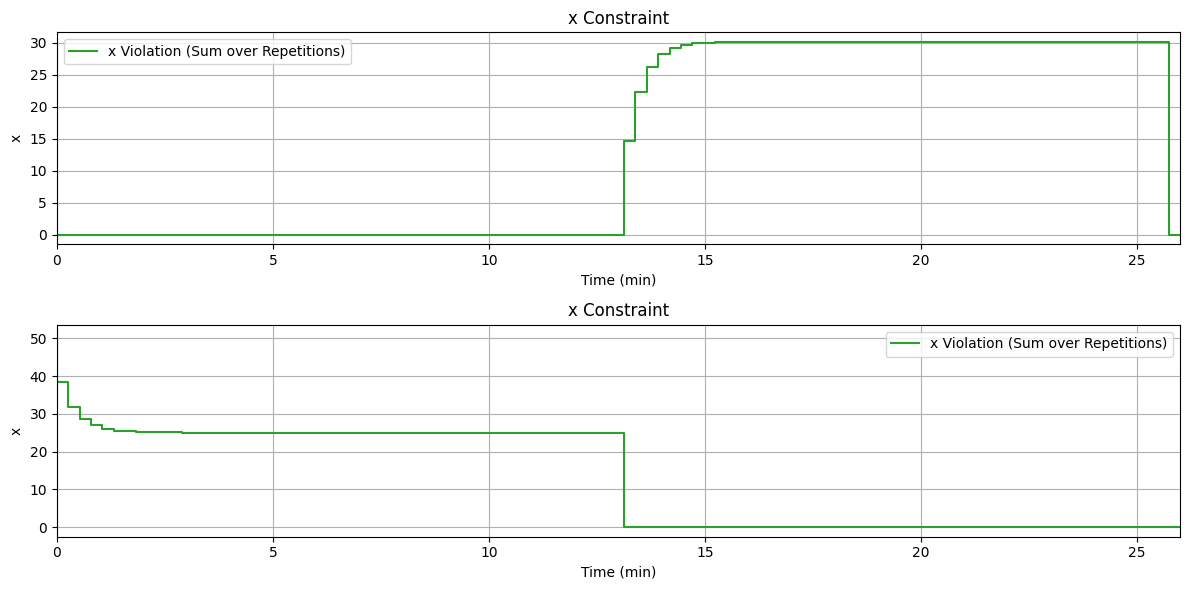

In [16]:
cons = {
    'x': [5,7.5]
}

cons_type = {
    'x': ['<=','>=']
}

env_params_fos.update({
'done_on_cons_vio':False,
'constraints': cons, 
'cons_type': cons_type,
'r_penalty': True})
env_params_fos.get('constraints') is not None
env = pcgym.Models_env(env_params_fos)
env.plot_rollout(fos_policy,10,cons_viol=True)

### 3.3 Multistage Extraction Constraint 

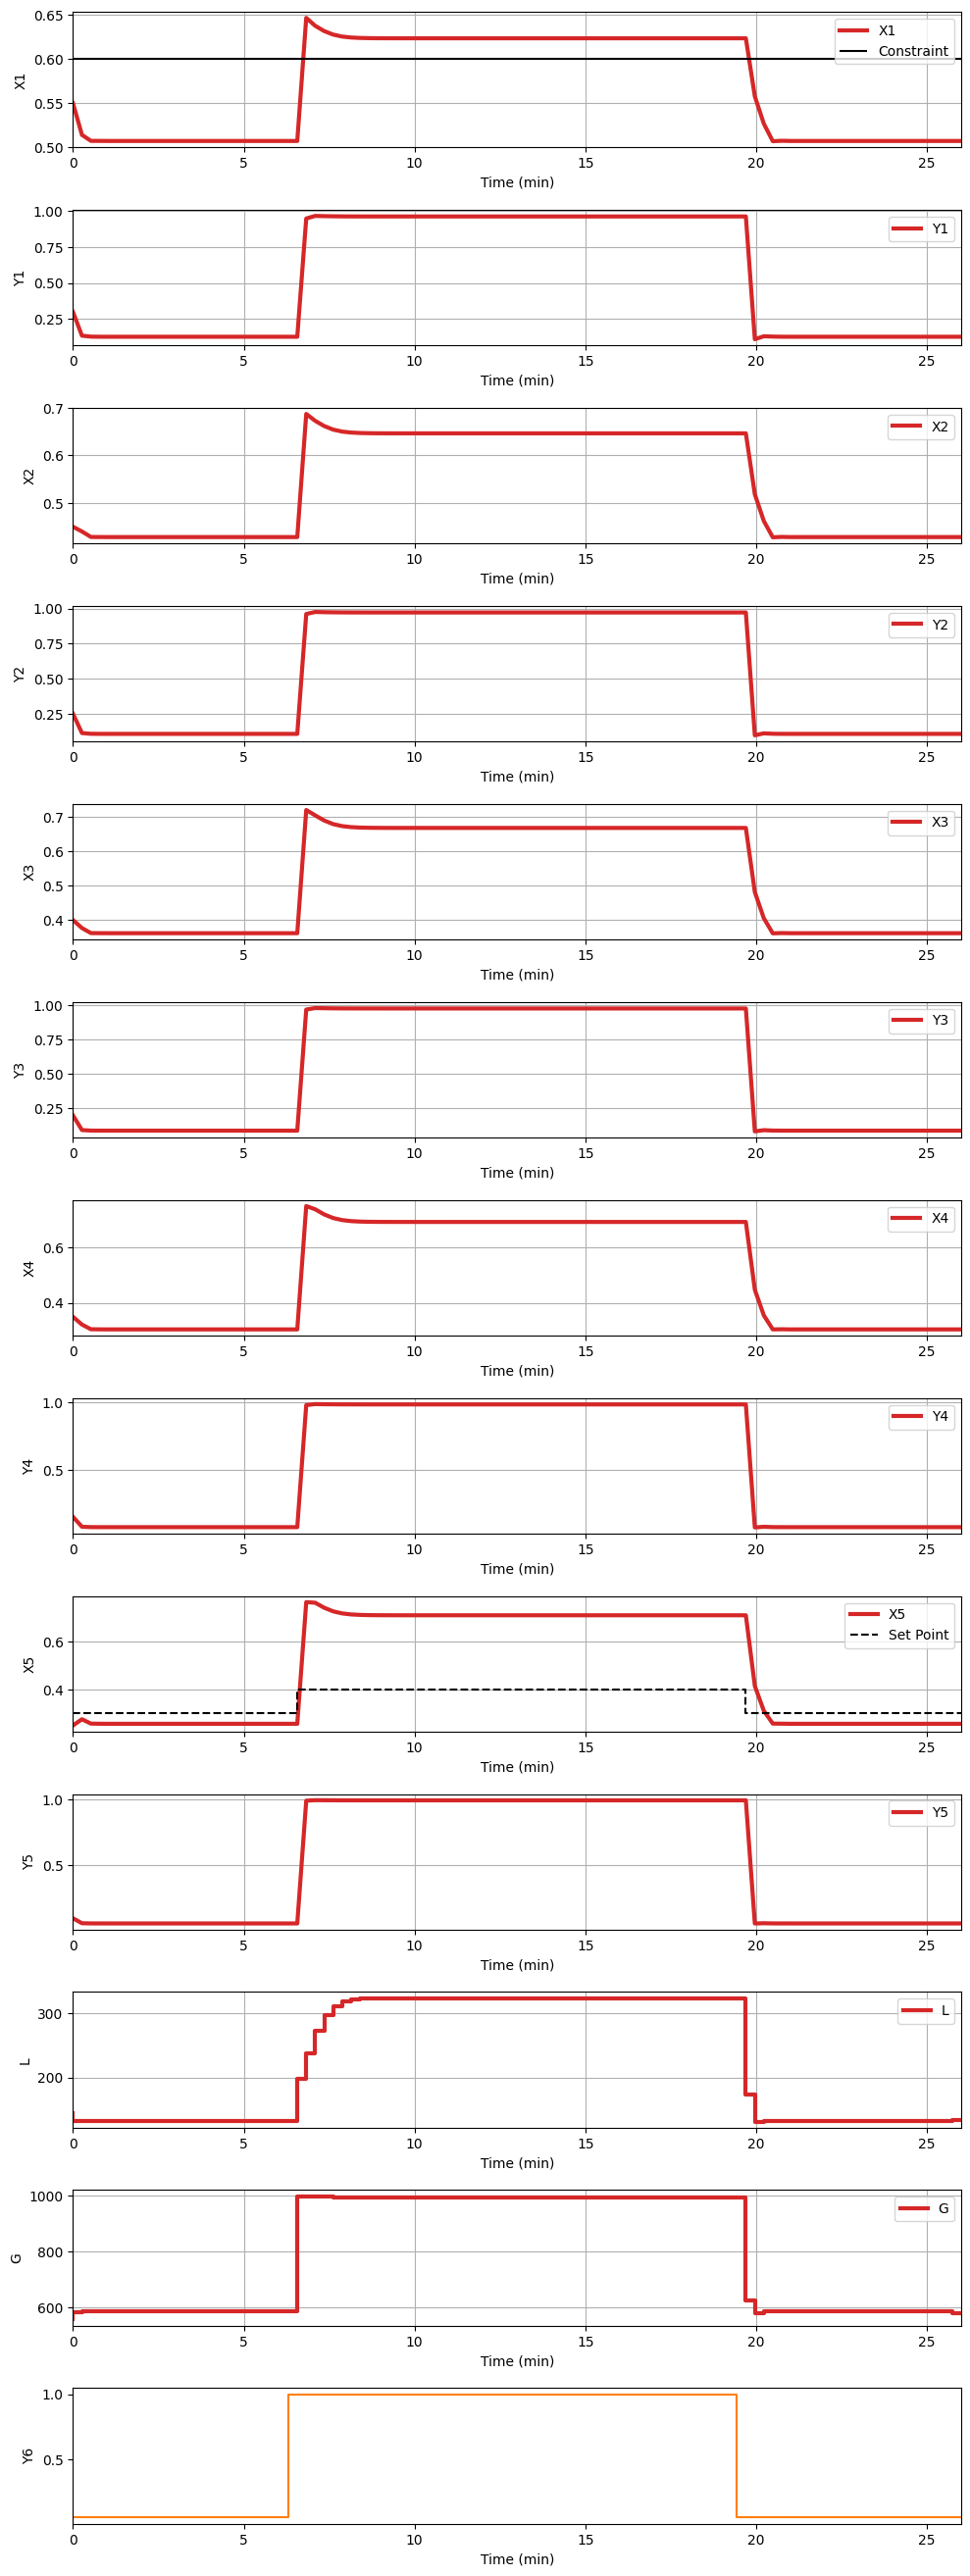

In [17]:
cons = {
    'X1': [0.6],
}

cons_type = {
    'X1':'<='
}

env_params_ms.update({
'done_on_cons_vio':False,
'constraints': cons, 
'cons_type': cons_type,
'r_penalty': True})
env_params_ms.get('constraints') is not None
env = pcgym.Models_env(env_params_ms)
env.plot_rollout(ms_policy,10)